# Train a Vision Transformer using Transfer Learning

In [1]:
import os
import torch
import torch.utils.data as data_utils
from torch import nn
from torch import optim
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
from utils.denormalize_image import denormalize_image

In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {DEVICE}')

Running on device: cpu


### Constants

In [3]:
FACES_FOLDER = os.path.join("data", "faces")
FACES_CSV = os.path.join(FACES_FOLDER, "faces.csv")
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
CLASS_NAMES = {0: "real", 1: "fake"}

### Data Preparation

In [4]:
from dataset.faces import Faces

In [5]:
# Take the dataset minus a certain % for training
train_dataset_full = Faces(root=FACES_FOLDER, csv=FACES_CSV, split="training", transform=True)
train_split_num_list = torch.arange(0, round((1 - VALIDATION_SPLIT) * len(train_dataset_full)))
train_dataset = data_utils.Subset(train_dataset_full, train_split_num_list)

# Take just a % of the dataset for validation
val_dataset_full = Faces(root=FACES_FOLDER, csv=FACES_CSV, split="validation", transform=True)
val_split_num_list = torch.arange(len(train_dataset), len(val_dataset_full))
val_dataset = data_utils.Subset(val_dataset_full, val_split_num_list)

print(f"Total dataset size: {len(train_dataset_full)}",
      f"Training dataset size {round((len(train_dataset) / len(train_dataset_full)) * 100)}%: {len(train_dataset)}",
      f"Validation dataset size {round((len(val_dataset) / len(train_dataset_full)) * 100)}%: {len(val_dataset)}", sep="\n")

Total dataset size: 8267
Training dataset size 80%: 6614
Validation dataset size 20%: 1653


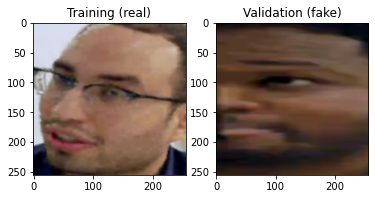

In [7]:
# plot some images
train_image, train_label = train_dataset[randint(0, len(train_dataset)-1)]
val_image, val_label = val_dataset[randint(0, len(val_dataset)-1)]
train_image = denormalize_image(train_image)
val_image = denormalize_image(val_image)

plt.subplot(1, 2, 1)
plt.title(f"Training ({CLASS_NAMES[train_label.int().item()]})")
plt.imshow(train_image)
plt.subplot(1, 2, 2)
plt.title(f"Validation ({CLASS_NAMES[val_label.int().item()]})")
plt.imshow(val_image)
plt.show()

In [8]:
# Create the Data Loaders for the train_dataset and val_dataset
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data_utils.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Train the model

In [129]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

#### Metrics

In [78]:
def get_accuracy(output_labels, y_true, sigmoid=True):
    if sigmoid:
        output_labels = torch.sigmoid(output_labels)
    assert y_true.ndim == 1 and y_true.size() == output_labels.size()
    output_labels = output_labels > 0.5
    return (y_true == output_labels).sum().item() / y_true.size(0)

In [83]:
# Test get_accuracy function
output_labels = torch.tensor([0.3, 0.2, 0.8, 0.9])
y_true = torch.tensor([1, 0, 0, 0])
get_accuracy(output_labels, y_true, sigmoid=False) # 0.25

0.25

#### Adapt InceptionResnetV1 to perform binary image classification

In [135]:
from facenet_pytorch import InceptionResnetV1

In [136]:
resnet = InceptionResnetV1(
    pretrained='vggface2',
    classify=True,
    num_classes=1, # 1 for binary classification
    device=DEVICE).eval()

In [137]:
resnet.to(device=DEVICE)
resnet.train()
print(f"Model in {DEVICE.upper()}")

Model in CPU


In [138]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet.parameters(), lr=LEARNING_RATE)

#### Overfit a batch of just 2 images to see if it's learning something

In [139]:
ex_train_loader = data_utils.DataLoader(train_dataset, batch_size=2)
ex_val_loader = data_utils.DataLoader(val_dataset, batch_size=2)
image, label = None, None
for images, labels in ex_val_loader:
    image, label = images, labels
    break
image = image.to(device=DEVICE)
label = label.to(device=DEVICE)

In [140]:
image.shape

torch.Size([2, 3, 256, 256])

In [141]:
# Forward pass
outputs = resnet(image).squeeze()
print(f"Outputs before sigmoid: {[round(o.item(), 3) for o in outputs]}")
outputs = nn.Sigmoid()(outputs)
print(f"Outputs after sigmoid: {[round(o.item(), 3) for o in outputs]}")

Outputs before sigmoid: [0.475, -0.485]
Outputs after sigmoid: [0.617, 0.381]


In [142]:
print(labels)

tensor([0., 0.])


In [143]:
# Train just two images to overfit them
total_acc = 0
epoch_divisions = 10
for epoch in range(100):
    # Forward pass
    outputs = resnet(image).squeeze()

    loss = criterion(outputs, label)
    acc = get_accuracy(outputs, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_acc += acc

    if (epoch + 1) % epoch_divisions == 0:
        print(f'Epoch [{epoch + 1}/{100}], Loss: {loss.item():.4f}, Acc: {((total_acc/epoch_divisions) * 100):.2f}%')
        total_acc = 0

Epoch [10/100], Loss: 0.6908, Acc: 50.00%
Epoch [20/100], Loss: 0.5815, Acc: 85.00%
Epoch [30/100], Loss: 0.5282, Acc: 85.00%
Epoch [40/100], Loss: 0.4749, Acc: 100.00%
Epoch [50/100], Loss: 0.4214, Acc: 100.00%
Epoch [60/100], Loss: 0.3704, Acc: 100.00%
Epoch [70/100], Loss: 0.3155, Acc: 100.00%
Epoch [80/100], Loss: 0.2651, Acc: 100.00%
Epoch [90/100], Loss: 0.2194, Acc: 100.00%
Epoch [100/100], Loss: 0.1794, Acc: 100.00%


As we see in the result below, the loss is decreasing.

#### Train the model

In [ ]:
print("Beginning training 🎨")

history = {
    "loss": {"train": [], "val": []},
    "acc": {"train": [], "val": []}
}

# Train just two images to overfit them
for epoch in range(NUM_EPOCHS):
    acc_per_epoch_train = 0
    loss_per_epoch_train = 0

    resnet.train()
    for i, (images_batch, labels_batch) in enumerate(tqdm(train_loader)):
        images_batch = images_batch.to(device=DEVICE)
        labels_batch = labels_batch.to(device=DEVICE)

        # Forward pass
        outputs = resnet(images_batch).squeeze()

        loss = criterion(outputs, labels_batch)
        acc = get_accuracy(outputs, labels_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc_per_epoch_train += acc
        loss_per_epoch_train += loss.item()

    with torch.no_grad():
        resnet.eval()
        acc_per_epoch_val = 0
        loss_per_epoch_val = 0
        for i, (images_batch, labels_batch) in enumerate(tqdm(val_loader)):
            images_batch = images_batch.to(device=DEVICE)
            labels_batch = labels_batch.to(device=DEVICE)

            # Forward pass
            outputs = resnet(images_batch).squeeze()

            loss = criterion(outputs, labels_batch)
            acc = get_accuracy(outputs, labels_batch)

            acc_per_epoch_val += acc
            loss_per_epoch_val += loss.item()

    history["loss"]["train"].append(loss_per_epoch_train / len(train_loader))
    history["loss"]["val"].append(loss_per_epoch_val / len(val_loader))
    history["acc"]["train"].append(acc_per_epoch_train / len(train_loader))
    history["acc"]["val"].append(acc_per_epoch_val / len(val_loader))

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
    print(f"\tTrain Loss: {history['loss']['train'][epoch]:.4f}, Train Acc: {history['acc']['train'][epoch]*100:.2f}%")
    print(f"\tVal Loss: {history['loss']['val'][epoch]:.4f}, Val Acc: {history['acc']['val'][epoch]*100:.2f}%", end="\n\n")
    

#### Model Evaluation